<a href="https://colab.research.google.com/github/surajmalaka29/Big-Data-Analytics-Project/blob/main/Ecommerce_Consumer_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install pyspark==3.5.1 pyarrow

import os
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("ecom-analytics-colab")
         .config("spark.sql.shuffle.partitions", "200")
         .config("spark.sql.execution.arrow.pyspark.enabled", "true")
         .getOrCreate())

spark

In [44]:
# Use Colab's upload button to select one or more CSVs from your machine
from google.colab import files
import io, pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


uploaded = files.upload()  # ← opens a file chooser; select 1+ CSVs

# Read all uploaded CSVs with pandas (infer dtypes once), then union them
pdf_list = []
for fname, content in uploaded.items():
    print(f"Loaded: {fname} ({len(content)} bytes)")
    pdf_list.append(pd.read_csv(io.BytesIO(content)))

# Concatenate locally (fast for ingestion), then send to Spark
import pandas as pd
pdf_all = pd.concat(pdf_list, ignore_index=True)

from pyspark.sql import types as T
df_raw = spark.createDataFrame(pdf_all)  # schema from pandas; we’ll fix types later

print("Rows:", df_raw.count(), "| Columns:", len(df_raw.columns))
df_raw.limit(5).show(truncate=False)
df_raw.printSchema()

Saving Ecommerce_Consumer_Behavior_Analysis_Data.csv to Ecommerce_Consumer_Behavior_Analysis_Data (2).csv
Loaded: Ecommerce_Consumer_Behavior_Analysis_Data (2).csv (194153 bytes)
Rows: 1000 | Columns: 28
+-----------+---+------+------------+--------------+---------------+----------+--------+--------------------+---------------+---------------------+----------------+-------------+--------------+-------------------------------------+----------------------+--------------------+-----------+---------------------+-------------------+------------------------+--------------+----------------+-------------+-------------------------------+---------------+-------------------+----------------+
|Customer_ID|Age|Gender|Income_Level|Marital_Status|Education_Level|Occupation|Location|Purchase_Category   |Purchase_Amount|Frequency_of_Purchase|Purchase_Channel|Brand_Loyalty|Product_Rating|Time_Spent_on_Product_Research(hours)|Social_Media_Influence|Discount_Sensitivity|Return_Rate|Customer_Satisfaction|E

In [36]:
# Quickly multiply rows by unioning jittered copies (adds tiny time/amount noise)
from pyspark.sql import functions as F

copies = 0   # set to 9 for ~10x, 49 for ~50x, etc.
df_scaled = df_raw

for i in range(copies):
    jitter = i + 1
    tmp = (df_raw
      .withColumn("Time_of_Purchase",
                  F.when(F.col("Time_of_Purchase").isNotNull(),
                         F.date_add(F.to_date("Time_of_Purchase", "M/d/yyyy"), jitter))
                   .otherwise(F.lit(None)))
      .withColumn("Purchase_Amount",
                  F.concat(F.lit("$"),
                           F.format_number(
                               (F.regexp_replace(F.col("Purchase_Amount"), "[$, ]", "")
                                 .cast("double") * (1 + 0.01*jitter)), 2))))
    df_scaled = df_scaled.unionByName(tmp)

df_raw = df_scaled.cache()
print("Scaled row count:", df_raw.count())


Scaled row count: 1000


In [37]:
from pyspark.sql import functions as F, types as T

# 3.1 sanitize column names → snake_case
def clean_col(c):
    return (c.strip()
             .replace("&", "and").replace("/", "_").replace("-", "_")
             .replace("(", "").replace(")", "").replace(" ", "_")
             .lower())

for c in df_raw.columns:
    df_raw = df_raw.withColumnRenamed(c, clean_col(c))

df = df_raw

# 3.2 friendly renames (only if present)
rename_map = {
    "purchase_amount": "amount_raw",
    "time_of_purchase": "purchase_ts",
    "purchase_channel": "channel",
    "purchase_category": "category",
    "frequency_of_purchase": "frequency",
    "time_spent_on_product_researchhours": "research_hours",
    "discount_used": "used_discount",
    "customer_loyalty_program_member": "loyalty_member",
    "customer_satisfaction": "csat",
    "device_used_for_shopping": "device",
    "purchase_intent": "intent",
    "time_to_decision": "decision_time",
}
for old, new in rename_map.items():
    if old in df.columns:
        df = df.withColumnRenamed(old, new)

# 3.3 parse/cast key fields defensively
def maybe(col):  # helper to avoid errors if col missing
    return col if col in df.columns else None

df = df.withColumn("amount",
                   F.regexp_replace(F.col(maybe("amount_raw")) if "amount_raw" in df.columns else F.lit(None),
                                    "[$, ]", "").cast("double")) if "amount_raw" in df.columns else df
df = df.withColumn("purchase_ts",
                   F.to_timestamp("purchase_ts", "M/d/yyyy")) if "purchase_ts" in df.columns else df

for c in ["used_discount","loyalty_member"]:
    if c in df.columns:
        df = df.withColumn(c, F.col(c).cast("boolean"))

for c in ["age","frequency","return_rate","brand_loyalty","product_rating","csat","decision_time"]:
    if c in df.columns:
        df = df.withColumn(c, F.col(c).cast("int"))

# 3.4 derive date parts
if "purchase_ts" in df.columns:
    # Set legacy time parser policy to handle the date format
    spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
    df = (df
          .withColumn("date", F.to_date("purchase_ts"))
          .withColumn("year_month", F.date_format("date", "yyyy-MM"))
          .withColumn("year_week",  F.date_format("date", "yyyy-Www"))) # Keeping the pattern that was intended

else:
    df = df.withColumn("date", F.lit(None).cast("date"))

df.cache()
df.printSchema()
df.select([c for c in ["customer_id","category","channel","amount","purchase_ts"] if c in df.columns]).limit(5).show(truncate=False)

root
 |-- customer_id: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- income_level: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- education_level: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- location: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amount_raw: string (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- channel: string (nullable = true)
 |-- brand_loyalty: integer (nullable = true)
 |-- product_rating: integer (nullable = true)
 |-- research_hours: double (nullable = true)
 |-- social_media_influence: string (nullable = true)
 |-- discount_sensitivity: string (nullable = true)
 |-- return_rate: integer (nullable = true)
 |-- csat: integer (nullable = true)
 |-- engagement_with_ads: string (nullable = true)
 |-- device: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- purchase_ts: timestamp (nullab

In [38]:
from pyspark.sql import functions as F, types as T

def have(cols):
    return [c for c in cols if c in df.columns]

row_count = df.count()
print(f"Row count: {row_count:,}")

# 4.1 Null counts (single pass)
nulls = df.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
print("Null counts per column:")
nulls.show(vertical=True, truncate=False)

# 4.2 Duplicates (exact row)
dup_all_rows = (df.groupBy([F.col(c) for c in df.columns]).count()
                  .filter("count > 1")
                  .agg(F.sum("count").alias("dup_rows"))
                  .collect()[0]["dup_rows"])
dup_all_rows = dup_all_rows or 0
print(f"Exact duplicate rows: {dup_all_rows:,} ({(dup_all_rows/row_count if row_count else 0):.4%})")

# 4.3 Business-key duplicates (customer_id + purchase_ts + amount)
keys = have(["customer_id","purchase_ts","amount"])
if len(keys) == 3:
    dup_key_rows = (df.groupBy(*keys).count()
                      .filter("count > 1")
                      .agg(F.sum("count").alias("dup_rows"))
                      .collect()[0]["dup_rows"]) or 0
    print(f"Key duplicates ({', '.join(keys)}): {dup_key_rows:,} ({(dup_key_rows/row_count if row_count else 0):.4%})")
else:
    print("Key duplicate check skipped (need: customer_id, purchase_ts, amount).")

# 4.4 Sanity checks
issues = []
if "amount" in df.columns:
    issues.append(("amount < 0", df.filter("amount < 0").count()))
    issues.append(("amount == 0", df.filter("amount = 0").count()))
if "age" in df.columns:
    issues.append(("age < 13", df.filter("age < 13").count()))
    issues.append(("age > 100", df.filter("age > 100").count()))
for name, lo, hi in [("product_rating",1,5), ("brand_loyalty",1,5), ("csat",1,10)]:
    if name in df.columns:
        issues.append((f"{name} outside [{lo},{hi}]",
                       df.filter((F.col(name) < lo) | (F.col(name) > hi)).count()))
print("\nSanity issues:")
for k,v in issues: print(f" - {k}: {v:,}")

# 4.5 Numeric describe
num_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (T.IntegerType, T.LongType, T.DoubleType, T.FloatType, T.ShortType))]
if num_cols:
    print("\nNumeric describe():")
    df.select(*num_cols).describe().show(truncate=False)

# 4.6 Date range + future rows
if "purchase_ts" in df.columns:
    df.agg(F.min("purchase_ts").alias("min_ts"),
           F.max("purchase_ts").alias("max_ts")).show(truncate=False)
    future_cnt = df.filter(F.col("purchase_ts") > F.current_timestamp()).count()
    print("Future-dated rows:", future_cnt)


Row count: 1,000
Null counts per column:
-RECORD 0---------------------
 customer_id            | 0   
 age                    | 0   
 gender                 | 0   
 income_level           | 0   
 marital_status         | 0   
 education_level        | 0   
 occupation             | 0   
 location               | 0   
 category               | 0   
 amount_raw             | 0   
 frequency              | 0   
 channel                | 0   
 brand_loyalty          | 0   
 product_rating         | 0   
 research_hours         | 0   
 social_media_influence | 247 
 discount_sensitivity   | 0   
 return_rate            | 0   
 csat                   | 0   
 engagement_with_ads    | 256 
 device                 | 0   
 payment_method         | 0   
 purchase_ts            | 0   
 used_discount          | 0   
 loyalty_member         | 0   
 intent                 | 0   
 shipping_preference    | 0   
 decision_time          | 0   
 amount                 | 0   
 date                   | 0  

+----------------+------+------------------+------------------+------------------+
|unique_customers|orders|revenue           |avg_order_value   |median_order_value|
+----------------+------+------------------+------------------+------------------+
|1000            |1000  |275063.88000000006|275.06388000000004|276.16499999999996|
+----------------+------+------------------+------------------+------------------+

+-------------------------+------+------------------+------+----------+
|category                 |orders|revenue           |aov   |avg_rating|
+-------------------------+------+------------------+------+----------+
|Jewelry & Accessories    |50    |15139.36          |302.79|2.76      |
|Sports & Outdoors        |51    |14610.51          |286.48|2.88      |
|Electronics              |54    |13842.41          |256.34|2.89      |
|Software & Apps          |43    |13601.409999999998|316.31|3.16      |
|Toys & Games             |47    |13536.46          |288.01|3.47      |
|Home Ap

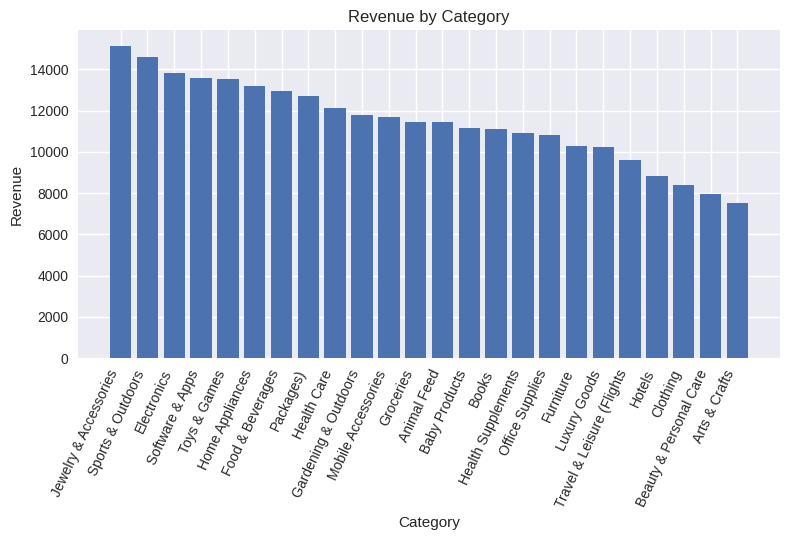

+--------+-----------------+------+------+
|channel |revenue          |orders|aov   |
+--------+-----------------+------+------+
|Mixed   |95164.36000000002|340   |279.9 |
|Online  |91604.22999999998|334   |274.26|
|In-Store|88295.28999999998|326   |270.84|
+--------+-----------------+------+------+

+----------+-----------------+------+------+
|device    |revenue          |orders|aov   |
+----------+-----------------+------+------+
|Tablet    |94001.79999999996|339   |277.29|
|Desktop   |93344.48999999999|350   |266.7 |
|Smartphone|87717.59000000003|311   |282.05|
+----------+-----------------+------+------+



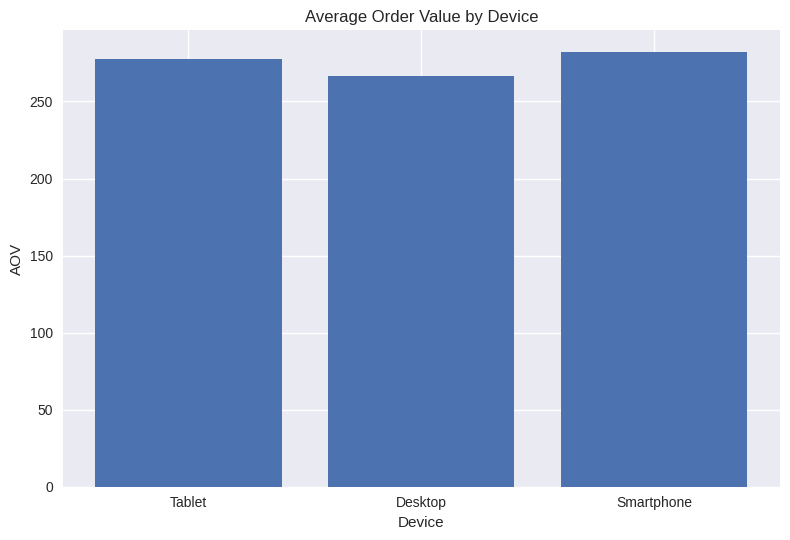

+-------------+------+------+-----------------+--------+
|used_discount|orders|aov   |avg_brand_loyalty|avg_csat|
+-------------+------+------+-----------------+--------+
|true         |521   |273.99|2.95             |5.43    |
|false        |479   |276.23|3.11             |5.37    |
+-------------+------+------+-----------------+--------+



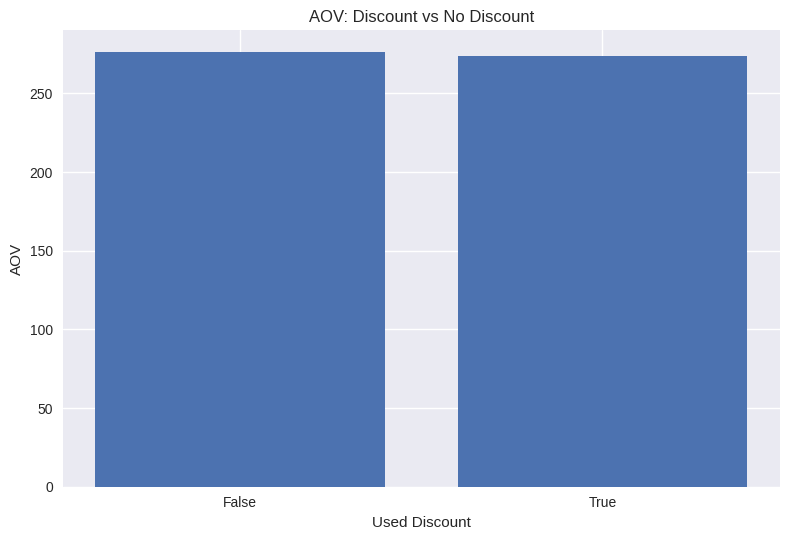

+----------+------------------+------+------+
|year_month|revenue           |orders|aov   |
+----------+------------------+------+------+
|2024-01   |19089.219999999998|75    |254.52|
|2024-02   |20294.280000000002|68    |298.45|
|2024-03   |27409.79          |93    |294.73|
|2024-04   |28617.219999999994|100   |286.17|
|2024-05   |18658.99000000001 |76    |245.51|
|2024-06   |25253.230000000003|89    |283.74|
|2024-07   |25260.620000000003|94    |268.73|
|2024-08   |27473.38999999999 |98    |280.34|
|2024-09   |24054.76          |84    |286.37|
|2024-10   |19492.379999999997|79    |246.74|
|2024-11   |21602.54          |80    |270.03|
|2024-12   |17857.46          |64    |279.02|
+----------+------------------+------+------+



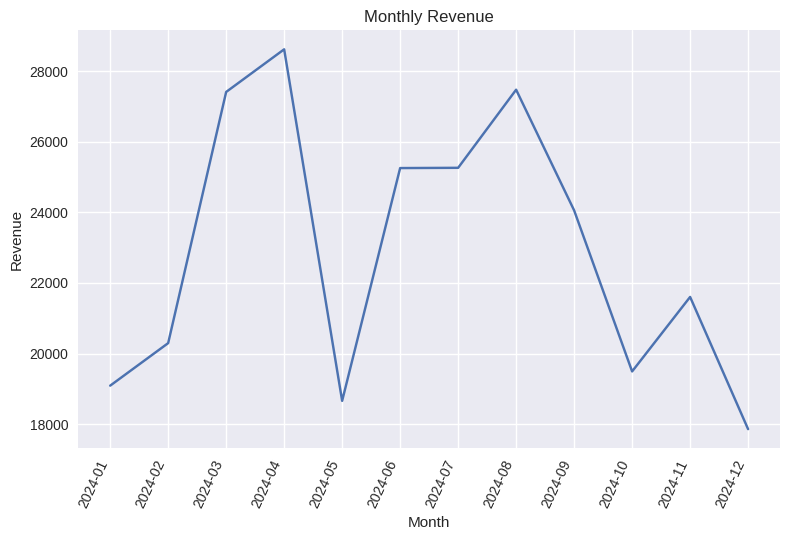

In [47]:
import matplotlib.pyplot as plt

from pyspark.sql import functions as F

# 5.1 KPIs
kpis = df.agg(
    F.countDistinct("customer_id").alias("unique_customers") if "customer_id" in df.columns else F.lit(None).alias("unique_customers"),
    F.count("*").alias("orders"),
    F.sum("amount").alias("revenue") if "amount" in df.columns else F.lit(None).alias("revenue"),
    F.avg("amount").alias("avg_order_value") if "amount" in df.columns else F.lit(None).alias("avg_order_value"),
    F.expr("percentile(amount, 0.5)").alias("median_order_value") if "amount" in df.columns else F.lit(None).alias("median_order_value")
)
kpis.show(truncate=False)

# 5.2 Category performance
if "category" in df.columns and "amount" in df.columns:
    cat_perf = (df.groupBy("category")
                  .agg(F.count("*").alias("orders"),
                       F.sum("amount").alias("revenue"),
                       F.round(F.avg("amount"),2).alias("aov"),
                       F.round(F.avg("product_rating"),2).alias("avg_rating") if "product_rating" in df.columns else F.lit(None).alias("avg_rating"))
                  .orderBy(F.desc("revenue")))
    cat_perf.show(30, truncate=False)

    # bar chart
    pdf = cat_perf.toPandas()
    plt.figure()
    plt.bar(pdf["category"], pdf["revenue"])
    plt.xticks(rotation=65, ha="right"); plt.title("Revenue by Category")
    plt.xlabel("Category"); plt.ylabel("Revenue")
    plt.tight_layout(); plt.show()

# 5.3 Channel & device breakdown
if "channel" in df.columns and "amount" in df.columns:
    chan = (df.groupBy("channel")
            .agg(F.sum("amount").alias("revenue"),
                 F.count("*").alias("orders"),
                 F.round(F.avg("amount"),2).alias("aov"))
            .orderBy(F.desc("revenue")))
    chan.show(truncate=False)

if "device" in df.columns and "amount" in df.columns:
    dev = (df.groupBy("device")
           .agg(F.sum("amount").alias("revenue"),
                F.count("*").alias("orders"),
                F.round(F.avg("amount"),2).alias("aov"))
           .orderBy(F.desc("revenue")))
    dev.show(truncate=False)

    pdf = dev.toPandas()
    plt.figure()
    plt.bar(pdf["device"], pdf["aov"])
    plt.title("Average Order Value by Device")
    plt.xlabel("Device"); plt.ylabel("AOV")
    plt.tight_layout(); plt.show()

# 5.4 Discount impact
if "used_discount" in df.columns and "amount" in df.columns:
    disc = (df.groupBy("used_discount")
            .agg(F.count("*").alias("orders"),
                 F.round(F.avg("amount"),2).alias("aov"),
                 F.round(F.avg("brand_loyalty"),2).alias("avg_brand_loyalty") if "brand_loyalty" in df.columns else F.lit(None).alias("avg_brand_loyalty"),
                 F.round(F.avg("csat"),2).alias("avg_csat") if "csat" in df.columns else F.lit(None).alias("avg_csat")))
    disc.show(truncate=False)

    pdf = disc.toPandas().sort_values("used_discount")
    plt.figure()
    plt.bar(pdf["used_discount"].astype(str), pdf["aov"])
    plt.title("AOV: Discount vs No Discount")
    plt.xlabel("Used Discount"); plt.ylabel("AOV")
    plt.tight_layout(); plt.show()

# 5.5 Time trends (monthly)
if "year_month" in df.columns and "amount" in df.columns:
    monthly = (df.groupBy("year_month")
               .agg(F.sum("amount").alias("revenue"),
                    F.count("*").alias("orders"),
                    F.round(F.avg("amount"),2).alias("aov"))
               .orderBy("year_month"))
    monthly.show(36, truncate=False)

    pdf = monthly.toPandas()
    plt.figure()
    plt.plot(pdf["year_month"], pdf["revenue"])
    plt.xticks(rotation=65, ha="right")
    plt.title("Monthly Revenue"); plt.xlabel("Month"); plt.ylabel("Revenue")
    plt.tight_layout(); plt.show()

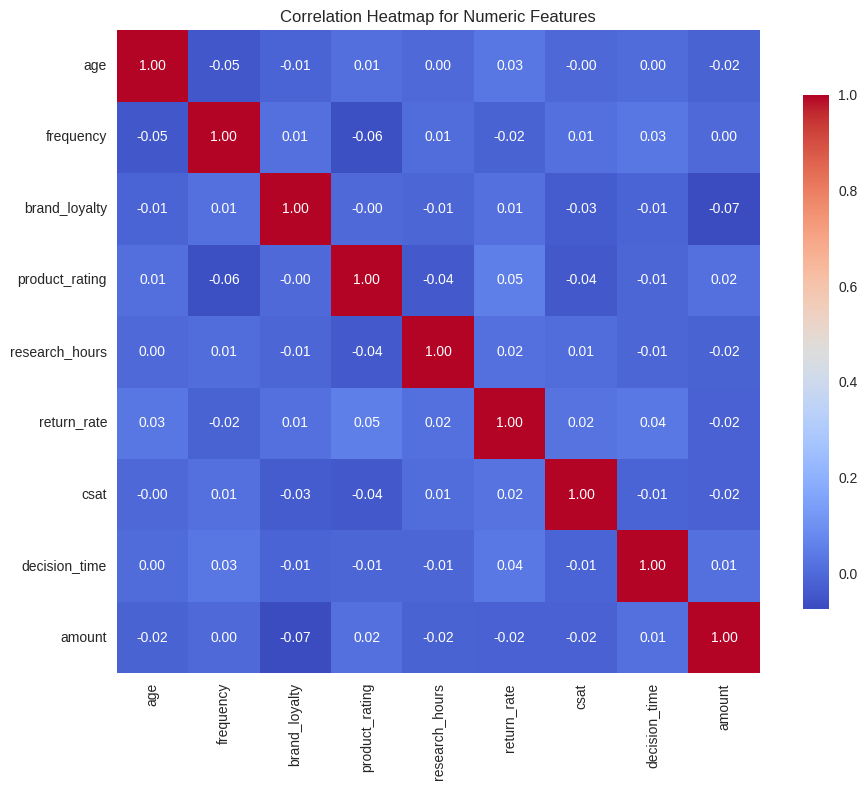

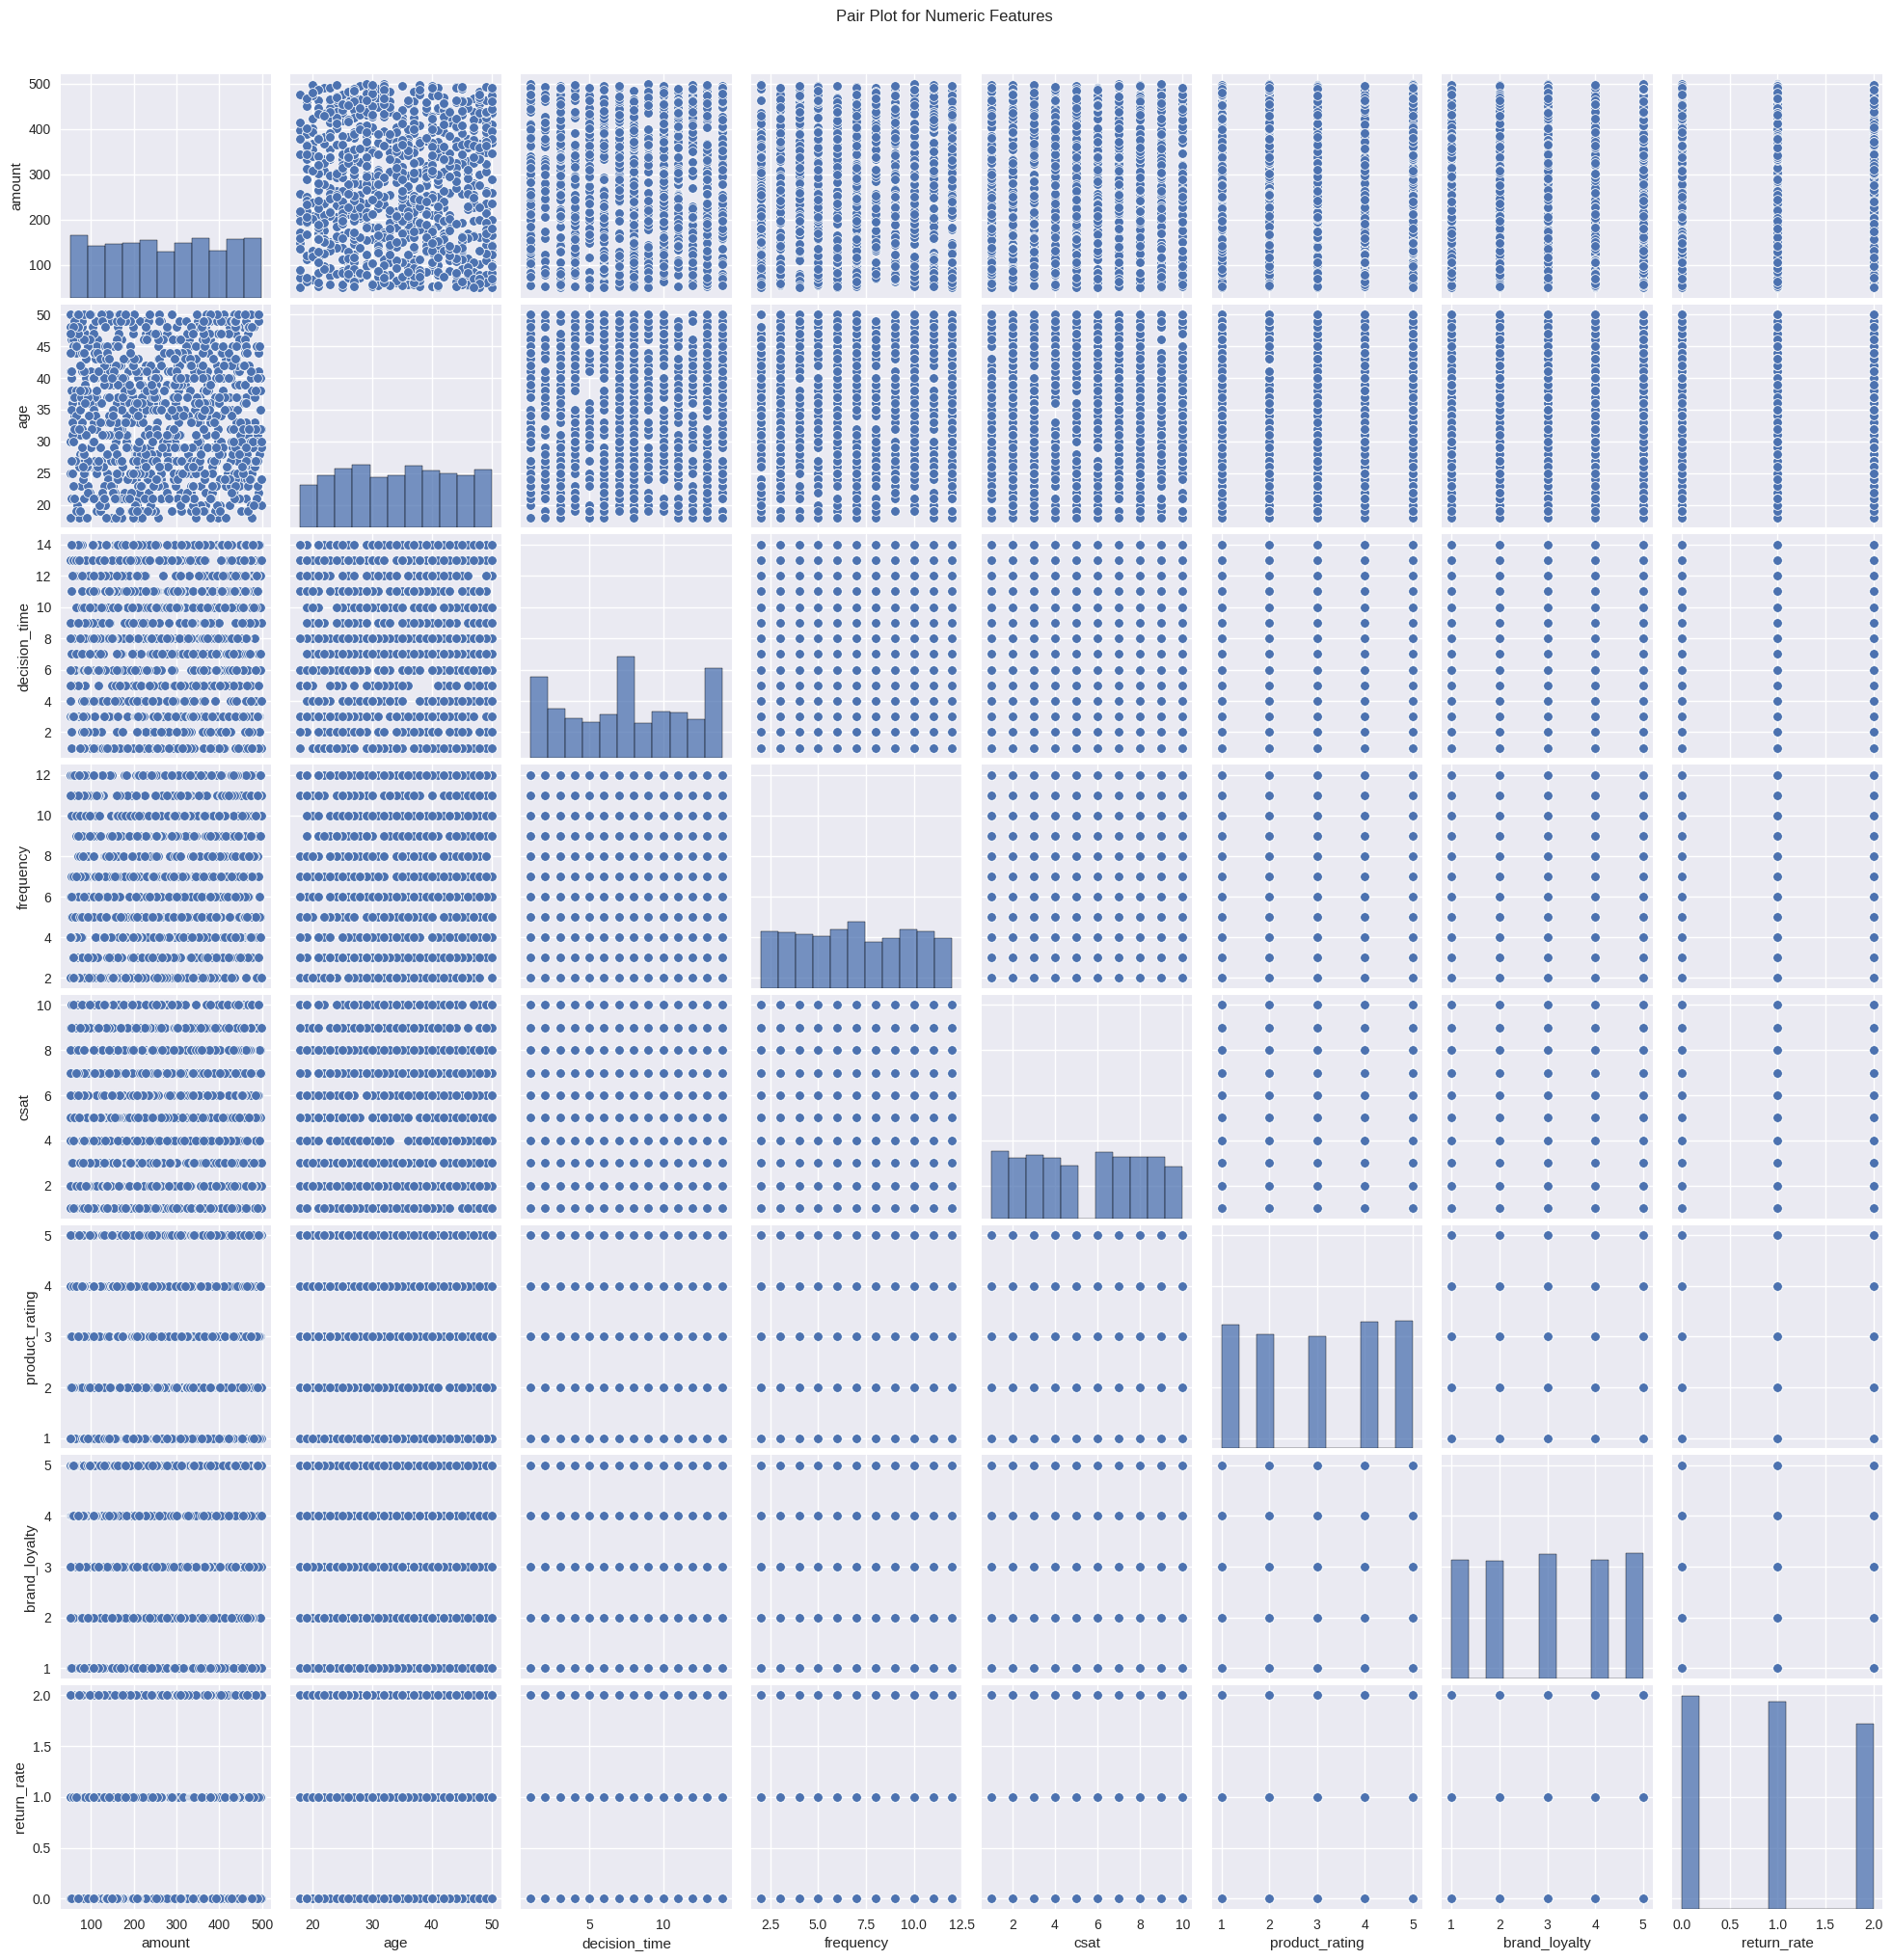

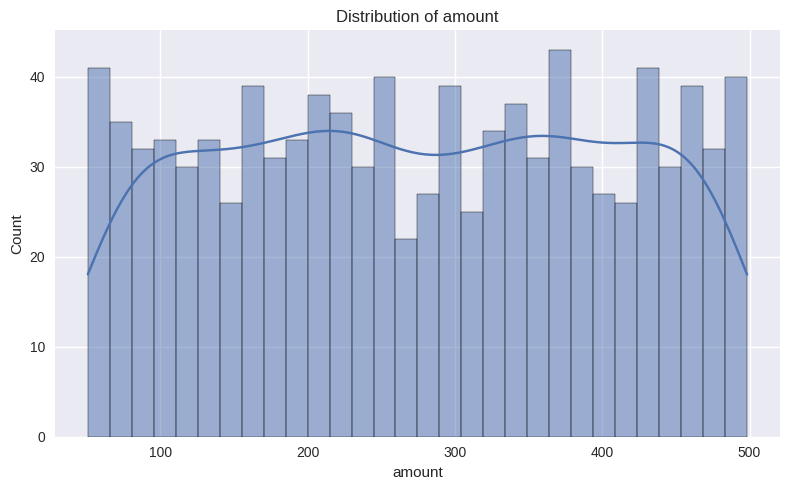

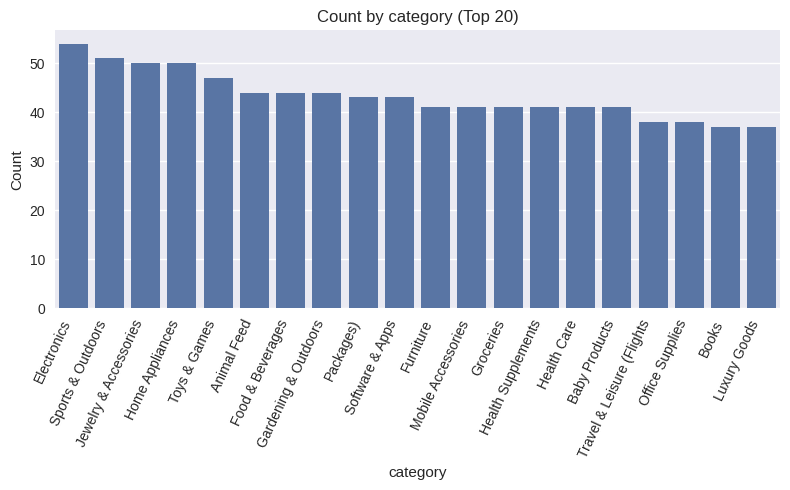

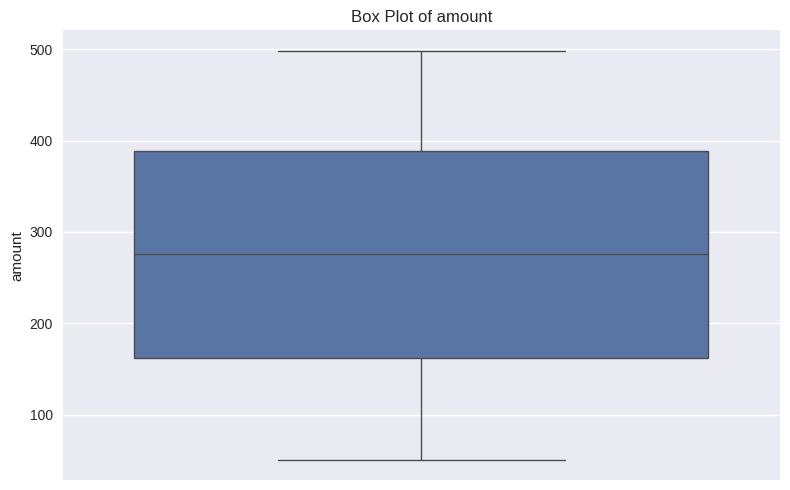

In [53]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from builtins import min as py_min # Import Python's built-in min

# ---------- 0) Helpers ----------
def spark_numeric_cols(sdf):
    numeric_types = (T.IntegerType, T.LongType, T.DoubleType, T.FloatType, T.ShortType, T.DecimalType)
    return [f.name for f in sdf.schema.fields if isinstance(f.dataType, numeric_types)]

def choose_best_numeric(pdf, max_cols=8):
    num_df = pdf.select_dtypes(include=[np.number])
    if num_df.shape[1] <= max_cols:
        return num_df
    # pick columns with highest variance (more informative)
    variances = num_df.var().sort_values(ascending=False)
    return num_df[variances.index[:max_cols]]

def first_available(sdf, candidates):
    return [c for c in candidates if c in sdf.columns]

# ---------- 1) Build a pandas working set (numeric + a couple categoricals) ----------
# numeric cols from Spark
num_cols = spark_numeric_cols(df)

# a couple of useful categorical columns if present
cat_candidates = ["age_restriction", "category", "channel", "gender", "income_level", "device"]
cat_cols = first_available(df, cat_candidates)[:2]

# select for plotting (guard empty numeric)
select_cols = num_cols + cat_cols
if not select_cols:
    raise ValueError("No numeric or categorical columns found for plotting.")

sdf_for_pd = df.select(*select_cols)

# sample to keep plots responsive (adjust target_n as needed)
target_n = 50000
row_count = sdf_for_pd.count()
# Use Python's built-in min() explicitly
frac = float(py_min(1.0, target_n / row_count)) if row_count else 1.0
sdf_sample = sdf_for_pd.sample(withReplacement=False, fraction=frac, seed=42) if frac < 1.0 else sdf_for_pd

pdf = sdf_sample.toPandas()  # collect to driver for seaborn/matplotlib

# clean any obviously non-numeric strings that slipped through (e.g., currency already cleaned earlier)
numeric_pdf = pdf.select_dtypes(include=[np.number])

# ---------- 2) Correlation Heatmap ----------
if numeric_pdf.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_pdf.corr(numeric_only=True)
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Heatmap for Numeric Features")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for a correlation heatmap (need ≥ 4). Found:", numeric_pdf.shape[1])

# ---------- 3) Pair Plot (limited to ≤ 8 numeric columns for speed) ----------
if numeric_pdf.shape[1] >= 2:
    pair_df = choose_best_numeric(pdf, max_cols=8)
    g = sns.pairplot(pair_df, diag_kind="hist")
    g.fig.suptitle("Pair Plot for Numeric Features", y=1.02)
    plt.show()
else:
    print("Not enough numeric columns for pair plot (need ≥ 2).")

# ---------- 4) Histogram of Price/Amount (fallbacks) ----------
amount_like = [c for c in ["amount", "price", "Purchase_Amount", "amount_raw"] if c in pdf.columns]
if amount_like:
    amt_col = amount_like[0]
    # ensure numeric for plotting (convert if needed)
    amt_series = pd.to_numeric(pdf[amt_col], errors="coerce").dropna()
    plt.figure(figsize=(8, 5))
    sns.histplot(amt_series, bins=30, kde=True)
    plt.title(f"Distribution of {amt_col}")
    plt.xlabel(amt_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No price/amount column found for histogram (looked for: amount, price, Purchase_Amount, amount_raw).")

# ---------- 5) Count Plot for a Categorical (fallbacks) ----------
cat_for_count = first_available(df, ["age_restriction", "category", "channel", "gender", "income_level", "device"])
if cat_for_count:
    cat_col = cat_for_count[0]
    # limit unique categories to keep plot readable
    top_k = 20
    vc = pdf[cat_col].value_counts().head(top_k)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=vc.index.astype(str), y=vc.values)
    plt.title(f"Count by {cat_col} (Top {top_k})")
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    plt.xticks(rotation=65, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No categorical column available for count plot.")

# ---------- 6) Box Plot for a Numeric (fallback to amount or any numeric) ----------
box_col = None
if "amount" in pdf.columns:
    box_col = "amount"
elif "price" in pdf.columns:
    box_col = "price"
elif numeric_pdf.shape[1] >= 1:
    box_col = numeric_pdf.columns[0]

if box_col:
    series = pd.to_numeric(pdf[box_col], errors="coerce").dropna()
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=series)
    plt.title(f"Box Plot of {box_col}")
    plt.tight_layout()
    plt.show()
else:
    print("No numeric column found for box plot.")

+-----------+----------------------+------+------+-----------------+
|customer_id|category              |spend |events|rating           |
+-----------+----------------------+------+------+-----------------+
|78-613-1546|Luxury Goods          |145.02|1     |5.48374359862794 |
|56-810-2066|Home Appliances       |490.34|1     |6.697136352510152|
|46-167-7999|Beauty & Personal Care|108.5 |1     |5.195924549256556|
|74-483-2893|Electronics           |101.29|1     |5.127811916468916|
|03-977-8103|Books                 |333.56|1     |6.312816235680323|
+-----------+----------------------+------+------+-----------------+
only showing top 5 rows

Sample recommendations:
+-----------+-------------------------+-------------+
|customer_id|category                 |score        |
+-----------+-------------------------+-------------+
|00-107-4749|Health Supplements       |0.99994254   |
|00-107-4749|Packages)                |4.0452452E-8 |
|00-107-4749|Food & Beverages         |8.123221E-9  |
|00-10

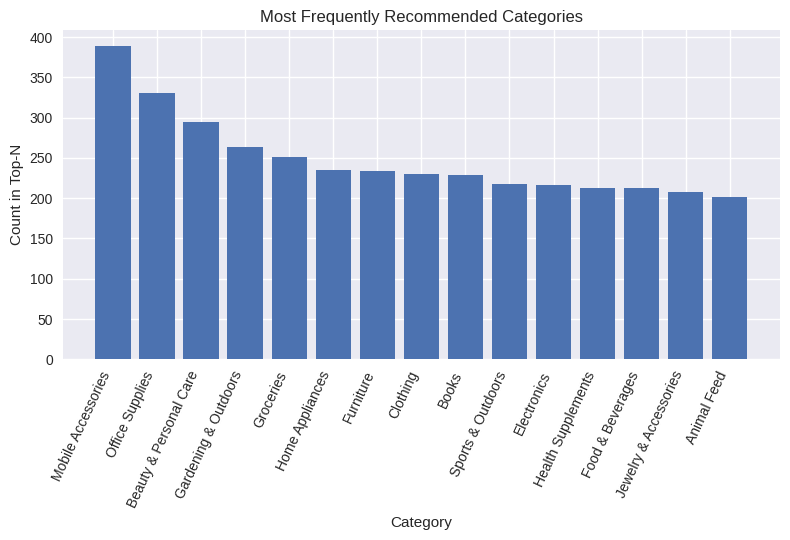

In [58]:
# Build implicit feedback signal from spend & events
from pyspark.sql import functions as F

required_cols = all(c in df.columns for c in ["customer_id","category"])
if required_cols:
    interactions = (df.groupBy("customer_id","category")
                      .agg(F.sum("amount").alias("spend") if "amount" in df.columns else F.lit(0.0).alias("spend"),
                           F.count("*").alias("events"))
                      .withColumn("rating", F.log1p(F.col("spend")) + 0.5*F.col("events")))
    interactions.show(5, truncate=False)

    # String indexers
    from pyspark.ml.feature import StringIndexer
    user_indexer = StringIndexer(inputCol="customer_id", outputCol="user_idx", handleInvalid="skip")
    item_indexer = StringIndexer(inputCol="category",    outputCol="item_idx", handleInvalid="skip")

    int_idx = user_indexer.fit(interactions).transform(interactions)
    int_idx = item_indexer.fit(int_idx).transform(int_idx)

    user_map = int_idx.select("customer_id","user_idx").dropDuplicates()
    item_map = int_idx.select("category","item_idx").dropDuplicates()

    # ALS implicit model
    from pyspark.ml.recommendation import ALS
    als = ALS(userCol="user_idx", itemCol="item_idx", ratingCol="rating",
              implicitPrefs=True, nonnegative=True, coldStartStrategy="drop",
              rank=32, maxIter=12, regParam=0.08, alpha=40)

    model = als.fit(int_idx)

    # Top-N recommendations per user
    topK = 5
    recs = model.recommendForAllUsers(topK)
    recs = (recs.withColumn("rec", F.explode("recommendations"))
                .select("user_idx",
                        F.col("rec.item_idx").alias("item_idx"),
                        F.col("rec.rating").alias("score"))
                .join(user_map, "user_idx")
                .join(item_map, "item_idx")
                .select("customer_id","category","score")
                .orderBy("customer_id", F.desc("score")))

    print("Sample recommendations:")
    recs.show(30, truncate=False)

    # Popularity fallback
    popular = (df.groupBy("category")
                 .agg(F.sum("amount").alias("revenue") if "amount" in df.columns else F.count("*").alias("orders"))
                 .orderBy(F.desc("revenue") if "amount" in df.columns else F.desc("orders")))
    popular.show(10, truncate=False)

    # Chart: most frequently recommended categories
    topcats = (recs.groupBy("category")
                    .agg(F.count("*").alias("times_recommended"))
                    .orderBy(F.desc("times_recommended"))
                    .limit(15)).toPandas()

    import matplotlib.pyplot as plt
    plt.figure()
    plt.bar(topcats["category"], topcats["times_recommended"])
    plt.xticks(rotation=65, ha="right")
    plt.title("Most Frequently Recommended Categories")
    plt.xlabel("Category"); plt.ylabel("Count in Top-N")
    plt.tight_layout(); plt.show()
else:
    print("Skipping ALS: need columns 'customer_id' and 'category'.")